# 🤖 Entrenamiento del Modelo Predictivo (PyCaret)

## 🎯 Objetivo
Este notebook orquesta el pipeline de entrenamiento de Machine Learning utilizando **PyCaret**.
El objetivo es encontrar y optimizar el mejor algoritmo capaz de predecir la probabilidad de **Enfermedad Cardíaca** basándose en biomarcadores clínicos.

## ⚙️ Estrategia de Modelado
1. **Preprocesamiento Robusto**: Normalización y manejo de outliers.
2. **Balanceo de Clases**: Uso de técnicas (SMOTE) para mitigar el desbalance entre pacientes sanos y enfermos.
3. **Optimización de Recall**: Priorizamos la **Sensibilidad (Recall)** sobre la Precisión.
   - *Contexto Médico*: Es peor no detectar a un enfermo (Falso Negativo) que alarmar a un sano (Falso Positivo).
4. **Selección de Modelos**: Comparación automática de +15 algoritmos.

## 📂 Entradas y Salidas
- **Input**: `data/02_intermediate/process_data.parquet` (Datos limpios).
- **Output**: `models/best_pipeline.pkl` (Modelo serializado listo para producción).

## 1. Configuración del Entorno

Definimos parámetros globales.
- **SAMPLE_FRAC**: Porcentaje de datos a usar. Para pruebas rápidas usamos `0.5`, para el modelo final debe ser `1.0`.
- **Rutas**: Ubicación de datos y donde se guardarán los artefactos.

### 🔹 Paso 1: Configuración del Entorno y Constantes
Inicializamos el entorno de trabajo importando **PyCaret** y definiendo constantes críticas:
- `SAMPLE_FRAC`: Controla el muestreo de datos. Usamos 0.5 (50%) para iteraciones rápidas de desarrollo, pero se debe cambiar a 1.0 para el entrenamiento final.
- `DATA_PATH` y `MODEL_DIR`: Definen las rutas de entrada de datos y salida del modelo, asegurando una estructura de proyecto ordenada.

In [1]:
import pandas as pd
from pycaret.classification import *
import os
import json

# ==========================================
# CONFIGURATION
# ==========================================
SAMPLE_FRAC = 1.0  # Using Full Dataset for Final Training
DATA_PATH = "../data/02_intermediate/process_data.parquet"
MODEL_DIR = "../models"
MODEL_NAME = "best_pipeline"
CONFIG_PATH = "../models/model_config.json"

SAMPLE_FRAC = 1.0  # Using Full Dataset for Final Training


## 2. Carga y Filtrado de Datos

Cargamos el dataset y aplicamos el esquema definido en `model_config.json`.
Es vital entrenar **solo** con las columnas que estarán disponibles en la aplicación final (Features + Target), descartando metadatos o IDs que causarían *data leakage*.

### 🔹 Paso 2: Carga y Selección de Features (Data Loading)
Cargamos el dataset procesado y aplicamos un filtro estricto de columnas basado en `model_config.json`.
**Importante**:
- Solo cargamos las columnas definidas como `features` y el `target`.
- Esto actúa como una barrera de seguridad contra el *data leakage*, asegurando que el modelo no vea variables que no estarán disponibles en producción (como IDs de pacientes o fechas de procesamiento).

In [2]:
# ==========================================
# 1. LOAD DATA
# ==========================================
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found at {DATA_PATH}")

df = pd.read_parquet(DATA_PATH)
print(f"Original Data Shape: {df.shape}")

# Load Schema Config
if os.path.exists(CONFIG_PATH):
    with open(CONFIG_PATH, 'r') as f:
        config = json.load(f)

    features = config['numeric_features'] + config['categorical_features']
    target = config['target']
    numeric_features = config['numeric_features']
    categorical_features = config['categorical_features']

    # Filter only relevant columns
    df = df[features + [target]]
else:
    print(f"Config file not found at {CONFIG_PATH}. Using default target and inferring features.")
    target = 'HeartDisease'
    numeric_features = None
    categorical_features = None
    # We do NOT filter df here because we don't know the exact features yet.
    # PyCaret will use all columns in df except target as features.

if SAMPLE_FRAC < 1.0:
    df = df.sample(frac=SAMPLE_FRAC, random_state=42)
    print(f"Sampled Data Shape: {df.shape}")
else:
    print("Using Full Dataset")


Original Data Shape: (43695, 29)
Using Full Dataset


In [3]:
import pandas as pd
import numpy as np

print("🕵️ Iniciando escaneo profundo de columnas problemáticas...")

found_problem = False
for col in df.columns:
    try:
        # Intentamos forzar la conversión a número de toda la columna
        # Si falla, saltará al 'except'
        pd.to_numeric(df[col], errors='raise')
    except Exception as e:
        found_problem = True
        print(f"\n🚨 ¡CULPABLE ENCONTRADO! Columna: '{col}'")
        print(f"   Tipo de dato actual: {df[col].dtype}")
        
        # Buscamos los valores que no son números
        non_numeric = df[pd.to_numeric(df[col], errors='coerce').isna()][col]
        unique_bad_values = non_numeric.unique()[:5] # Mostramos solo los primeros 5 ejemplos
        
        print(f"   Valores basura detectados (ejemplos): {unique_bad_values}")
        
        # --- INTENTO DE REPARACIÓN AUTOMÁTICA ---
        print(f"   🛠️ Intentando reparar '{col}'...")
        
        # 1. Convertir a string
        df[col] = df[col].astype(str)
        # 2. Limpiar corchetes y comillas extrañas
        df[col] = df[col].str.replace(r'[\[\]]', '', regex=True)
        # 3. Forzar de nuevo a numérico
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Llenar nulos resultantes con 0 o la media (según prefieras, aquí uso 0 para seguridad)
        df[col] = df[col].fillna(0)
        print(f"   ✅ Columna '{col}' reparada y convertida a numérica.")

if not found_problem:
    print("\n🤷‍♂️ No se encontraron fallos de conversión directa.")
    print("Si el error persiste, verifica si la columna 'target' tiene valores extraños.")
else:
    print("\n🎉 Limpieza terminada. Ahora vuelve a ejecutar setup().")

🕵️ Iniciando escaneo profundo de columnas problemáticas...

🤷‍♂️ No se encontraron fallos de conversión directa.
Si el error persiste, verifica si la columna 'target' tiene valores extraños.


## 3. Configuración del Experimento (Setup)

La función `setup()` inicializa el entorno de PyCaret y crea el pipeline de transformación.
- **normalize=True**: Escala las variables para que tengan rangos comparables. Usamos `RobustScaler` para ser resilientes a outliers.
- **remove_outliers=True**: Elimina anomalías estadísticas que podrían sesgar el modelo.
- **fix_imbalance=True**: Aplica SMOTE para generar muestras sintéticas de la clase minoritaria (Enfermos), mejorando el aprendizaje.

### 🔹 Paso 3: Inicialización del Experimento (PyCaret Setup)
Configuramos el pipeline de preprocesamiento automático con `setup()`. Aquí definimos la "magia" de PyCaret:
- **Normalización**: Aplicamos `RobustScaler` (`normalize_method='robust'`) para escalar los datos manejando bien los outliers típicos de datos clínicos.
- **Balanceo de Clases**: Activamos `fix_imbalance=True` (SMOTE) para generar datos sintéticos de la clase minoritaria (pacientes enfermos), evitando que el modelo se sesgue hacia la clase mayoritaria (sanos).
- **Tipos de Datos**: Definimos explícitamente cuáles son numéricas y cuáles categóricas.

In [4]:
# =============================================================================
# 1. SETUP MEJORADO (Ingeniería de Features Agresiva)
# =============================================================================
# Forzamos transformaciones que ayudan a los árboles a encontrar "cortes" mejores
exp = setup(
    data=df,
    target=target,
    numeric_features=numeric_features,
    categorical_features=categorical_features,
    normalize=True,
    normalize_method='robust',
    # polynomial_features=False,  <-- DESACTIVADO PARA VELOCIDAD
    remove_multicollinearity=True,
    multicollinearity_threshold=0.90,
    fix_imbalance=True, # SMOTE sigue activo (importante)
    session_id=42,
    n_jobs=1,
    verbose=True
)

# =============================================================================
# 2. DEFINIR EL ESPACIO DE BÚSQUEDA (Grid Search Manual)
# =============================================================================
# Aquí está el secreto. No dejamos que el modelo adivine.
# Le damos parámetros que sabemos que funcionan para casos médicos difíciles.

# Calculamos el peso sugerido
neg_count = (df[target] == 0).sum()
pos_count = (df[target] == 1).sum()
scale_weight = neg_count / pos_count

xgb_grid = {
    'learning_rate': [0.05, 0.1],      # Menos opciones
    'n_estimators': [100, 200],        # Menos árboles
    'max_depth': [3, 5],               # Menos profundidad
    'scale_pos_weight': [scale_weight, scale_weight * 1.5],
    'max_delta_step': [1]              # Valor seguro
}


  File "c:\Users\OMAR\miniconda3\envs\xgb_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\OMAR\miniconda3\envs\xgb_env\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\OMAR\miniconda3\envs\xgb_env\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\OMAR\miniconda3\envs\xgb_env\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


,Description,Value
0,Session id,42
1,Target,HeartDisease
2,Target type,Binary
3,Original data shape,"(43695, 28)"
4,Transformed data shape,"(72719, 31)"
5,Transformed train set shape,"(59610, 31)"
6,Transformed test set shape,"(13109, 31)"
7,Numeric features,20
8,Categorical features,7
9,Preprocess,True


In [ ]:
# =============================================================================
# 3. CREAR Y AFINAR (Tuning)
# =============================================================================
print("🚀 Iniciando Tuning Rápido...")
xgb = create_model('xgboost', verbose=False)

tuned_xgb = tune_model(
    xgb, 
    custom_grid=xgb_grid, 
    optimize='Recall', 
    n_iter=10,  # Solo 10 intentos
    choose_better=True,
    verbose=True
)

🚀 Iniciando Tuning Rápido...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6175,0.8945,0.9872,0.0618,0.1163,0.0718,0.1909
1,0.6198,0.9048,0.9872,0.0621,0.1169,0.0724,0.1918
2,0.6195,0.8892,0.9872,0.0621,0.1168,0.0723,0.1917
3,0.6368,0.9063,0.9872,0.0649,0.1217,0.0776,0.1989
4,0.6342,0.9123,0.9872,0.0644,0.1210,0.0768,0.1978
5,0.6270,0.9029,0.9873,0.0640,0.1203,0.0754,0.1960
6,0.6259,0.8935,0.9744,0.0624,0.1173,0.0728,0.1904
7,0.6246,0.9087,0.9872,0.0629,0.1183,0.0739,0.1938
8,0.6174,0.8889,0.9872,0.0618,0.1163,0.0718,0.1909


Fitting 10 folds for each of 16 candidates, totalling 160 fits


In [6]:
# =============================================================================
# 4. CALIBRACIÓN (Arreglar las probabilidades)
# =============================================================================
print("Calibrando probabilidades...")
calibrated_xgb = calibrate_model(tuned_xgb, method='isotonic')

# Ahora sí, este es tu modelo final para evaluar
final_model_to_use = calibrated_xgb
tuned_model = final_model_to_use # Alias para compatibilidad con celdas posteriores
print("Modelo listo para análisis de umbral.")

Calibrando probabilidades...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9068,0.8976,0.5769,0.1515,0.2400,0.2080,0.2621
1,0.9065,0.9046,0.5385,0.1438,0.2270,0.1946,0.2439
2,0.8921,0.8868,0.4615,0.1111,0.1791,0.1439,0.1869
3,0.9013,0.9023,0.6026,0.1478,0.2374,0.2048,0.2643
4,0.9117,0.9120,0.5641,0.1571,0.2458,0.2145,0.2651
5,0.9153,0.9017,0.5443,0.1617,0.2493,0.2181,0.2643
6,0.9147,0.8908,0.4744,0.1440,0.2209,0.1892,0.2276
7,0.9055,0.9083,0.5513,0.1448,0.2293,0.1969,0.2481
8,0.8950,0.8854,0.5128,0.1238,0.1995,0.1652,0.2143


Modelo listo para análisis de umbral.


Generando Curva ROC...


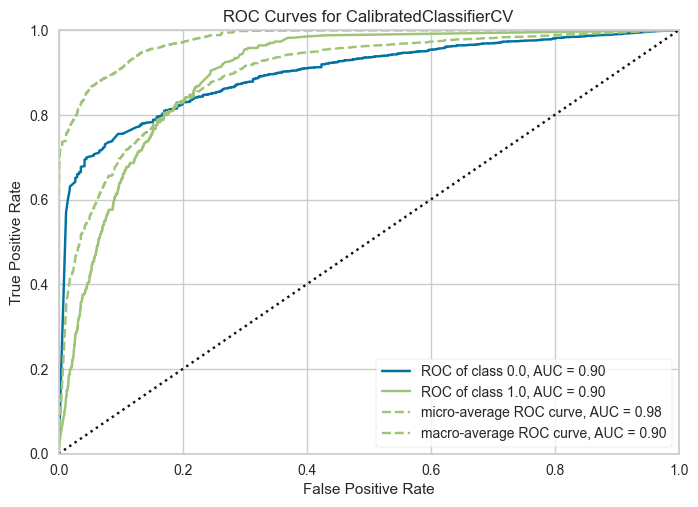

,FPR,TPR,Threshold
0,0.0000,0.0000,inf
1,0.0189,0.1970,0.8813
2,0.0265,0.2746,0.8346
3,0.0355,0.3463,0.7590
4,0.0487,0.4060,0.6889
5,0.0600,0.4687,0.6313
6,0.0704,0.5284,0.5770
7,0.0836,0.5761,0.5201
8,0.0974,0.6328,0.4475
9,0.1101,0.6776,0.3648


In [7]:
# 1. Curva ROC (Discriminación General)
print("Generando Curva ROC...")
plot_model(tuned_model, plot='auc')

# --- DATOS TABULARES (ROC) ---
try:
    # PyCaret no expone fácil los datos de la curva, pero podemos recalcularlos para la tabla
    from sklearn.metrics import roc_curve, auc
    X_test = get_config('X_test_transformed')
    y_test = get_config('y_test')
    y_prob = tuned_model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
    # Muestrear para no mostrar miles de filas
    display(roc_df.iloc[::len(roc_df)//20].reset_index(drop=True).style.format('{:.4f}'))
except Exception as e:
    print(f"No se pudo generar tabla ROC: {e}")


Generando Curva Precision-Recall...


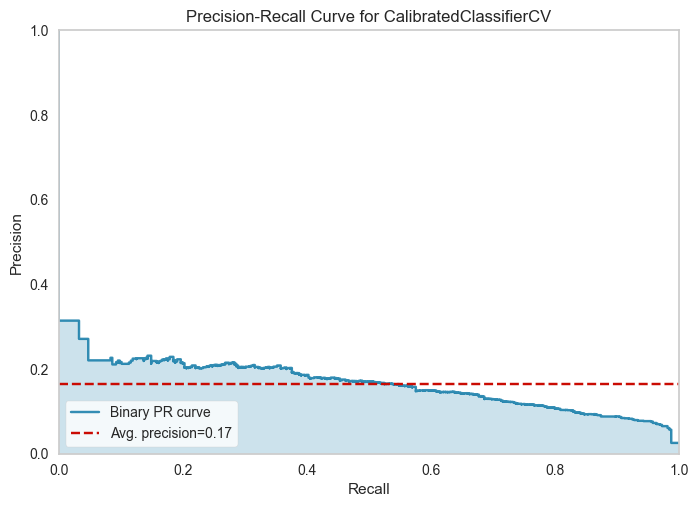

,Precision,Recall,Threshold
0,0.0256,1.0000,0.0000
1,0.0720,0.9642,0.0254
2,0.0806,0.9284,0.0476
3,0.0932,0.8478,0.0868
4,0.0971,0.8418,0.1072
5,0.1003,0.8299,0.1277
6,0.1037,0.8090,0.1532
7,0.1090,0.8000,0.1813
8,0.1137,0.7821,0.2152
9,0.1178,0.7403,0.2504


In [8]:
# 2. Curva Precision-Recall (Crucial para Desbalance)
print("Generando Curva Precision-Recall...")
plot_model(tuned_model, plot='pr')

# --- DATOS TABULARES (PR) ---
try:
    from sklearn.metrics import precision_recall_curve
    prec, rec, thresh = precision_recall_curve(y_test, y_prob)
    pr_df = pd.DataFrame({'Precision': prec[:-1], 'Recall': rec[:-1], 'Threshold': thresh})
    display(pr_df.iloc[::len(pr_df)//20].reset_index(drop=True).style.format('{:.4f}'))
except Exception as e:
    print(f"No se pudo generar tabla PR: {e}")


Generando Matriz de Confusión...


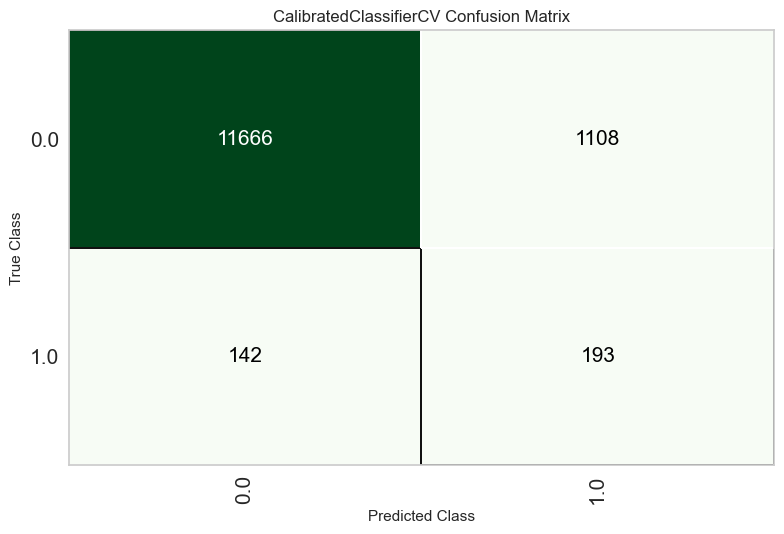

In [9]:
# 3. Matriz de Confusión
print("Generando Matriz de Confusión...")
plot_model(tuned_model, plot='confusion_matrix')


Generando Gráfico de Error...


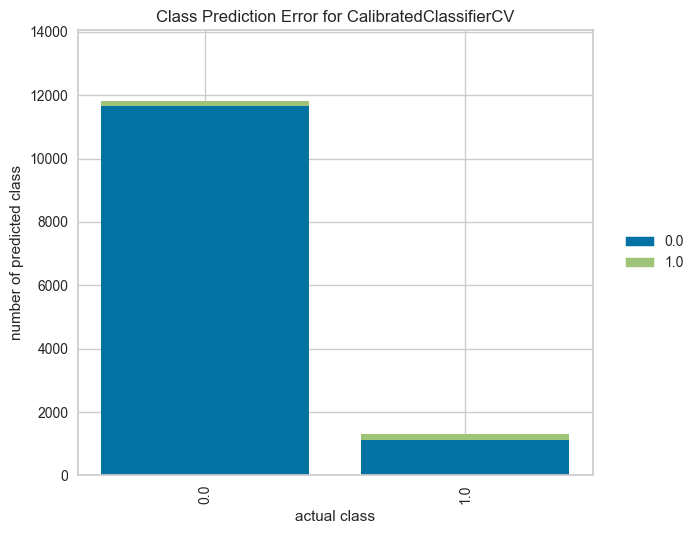

In [10]:
# 4. Error de Predicción (Validación Cruzada)
print("Generando Gráfico de Error...")
plot_model(tuned_model, plot='error')


Generando Curva de Calibración...


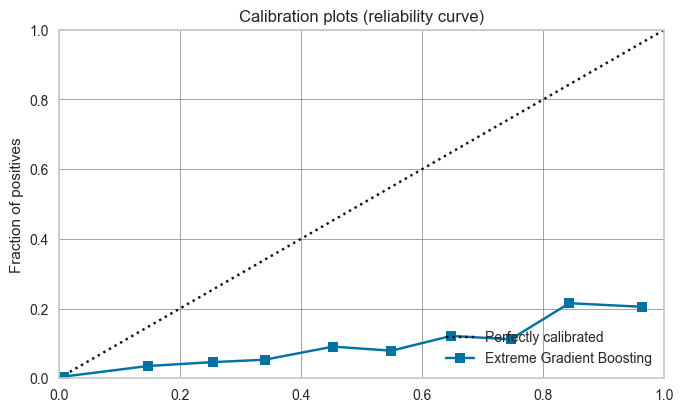

In [11]:
# 5. Curva de Calibración (Confiabilidad)
print("Generando Curva de Calibración...")
plot_model(tuned_model, plot='calibration')


Generando gráfico SHAP (Feature Importance)...


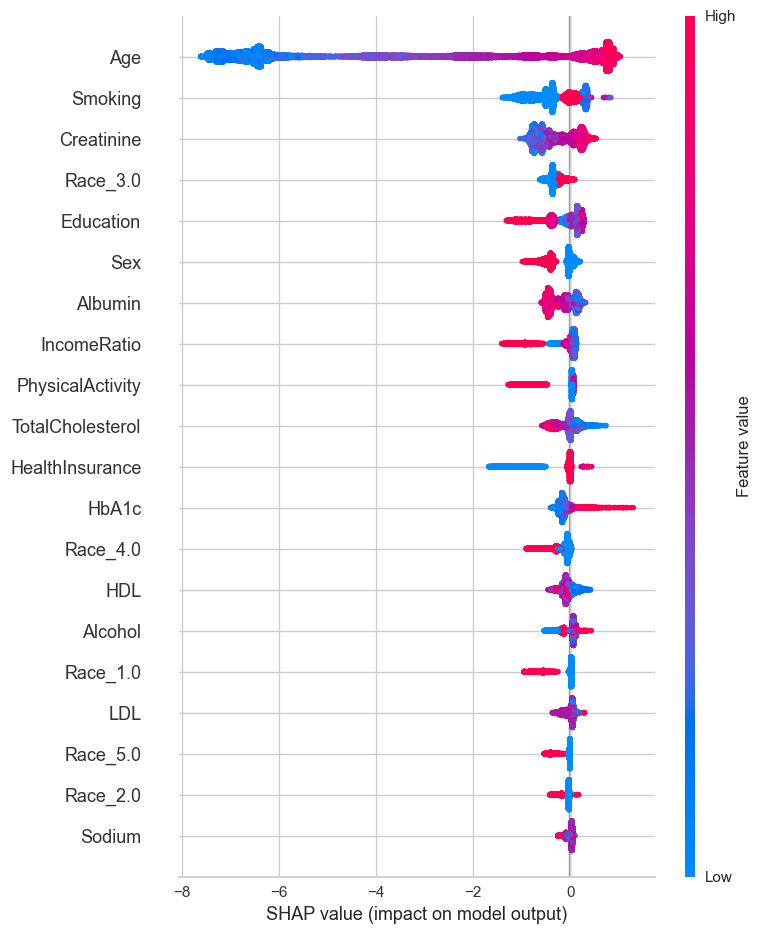

In [29]:
# Usamos 'tuned_xgb' (sin calibrar) porque SHAP requiere el modelo de árbol original, no el calibrado.
# 6. Explicabilidad del Modelo (SHAP)
# Entendiendo qué variables influyen más en la predicción
print("Generando gráfico SHAP (Feature Importance)...")
try:
    interpret_model(tuned_xgb)
except Exception as e:
    print(f"No se pudo generar SHAP: {e}")


🎯 PUNTO ÓPTIMO ENCONTRADO (Max F2-Score)
✅ Mejor Umbral: 0.40
📊 F2-Score:     0.3829
📈 Recall:       0.6627 (Detectas este % de enfermos)
🎯 Precisión:    0.1424 (De tus alertas, este % es real)


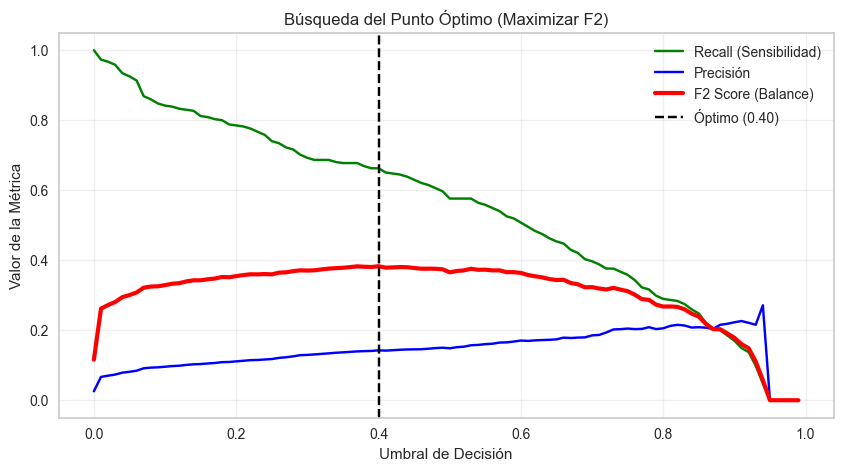

In [12]:
# 3. Estrategia de Umbral Óptimo (Maximizar F2-Score)
from sklearn.metrics import fbeta_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Obtener las probabilidades del modelo actual (tuned_model)
# Usamos el set de prueba transformado
X_test = get_config('X_test_transformed')
y_test = get_config('y_test')
y_prob = tuned_model.predict_proba(X_test)[:, 1]

# 2. Calcular F2-Score para todos los umbrales posibles
thresholds = np.arange(0.0, 1.0, 0.01)
scores = []

for t in thresholds:
    # Convertir probabilidad a predicción dura (0 o 1) usando el umbral 't'
    y_pred = (y_prob >= t).astype(int)
    
    # Calcular métricas (beta=2 prioriza Recall)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    
    # Guardamos también recall y precision para ver el trade-off
    from sklearn.metrics import precision_score, recall_score
    rec = recall_score(y_test, y_pred, zero_division=0)
    prec = precision_score(y_test, y_pred, zero_division=0)
    
    scores.append({'Threshold': t, 'F2': f2, 'Recall': rec, 'Precision': prec})

# 3. Encontrar el ganador
df_scores = pd.DataFrame(scores)
best_row = df_scores.loc[df_scores['F2'].idxmax()] # Fila con el F2 máximo

print("="*40)
print(f"🎯 PUNTO ÓPTIMO ENCONTRADO (Max F2-Score)")
print("="*40)
print(f"✅ Mejor Umbral: {best_row['Threshold']:.2f}")
print(f"📊 F2-Score:     {best_row['F2']:.4f}")
print(f"📈 Recall:       {best_row['Recall']:.4f} (Detectas este % de enfermos)")
print(f"🎯 Precisión:    {best_row['Precision']:.4f} (De tus alertas, este % es real)")
print("="*40)

# 4. Gráfico para entender visualmente el punto óptimo
plt.figure(figsize=(10, 5))
plt.plot(df_scores['Threshold'], df_scores['Recall'], label='Recall (Sensibilidad)', color='green')
plt.plot(df_scores['Threshold'], df_scores['Precision'], label='Precisión', color='blue')
plt.plot(df_scores['Threshold'], df_scores['F2'], label='F2 Score (Balance)', color='red', linewidth=3)

# --- CORRECCIÓN AQUÍ ---
# Usamos comillas dobles "..." para el f-string para que no choquen con las simples de ['Threshold']
plt.axvline(best_row['Threshold'], color='black', linestyle='--', label=f"Óptimo ({best_row['Threshold']:.2f})")
# -----------------------

plt.title('Búsqueda del Punto Óptimo (Maximizar F2)')
plt.xlabel('Umbral de Decisión')
plt.ylabel('Valor de la Métrica')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [13]:
# ==========================================
# 4. FINALIZE & SAVE
# ==========================================
final_model = finalize_model(tuned_model)
os.makedirs(MODEL_DIR, exist_ok=True)
save_path = os.path.join(MODEL_DIR, MODEL_NAME)
save_model(final_model, save_path)
print(f"Model saved successfully to {save_path}.pkl")

Transformation Pipeline and Model Successfully Saved
Model saved successfully to ../models\best_pipeline.pkl
